# **A complete analysis for predicting banking behavior by the classification method.**

##                      <center>  By Huanwang (Henry) Yang </center>

---

## **Objective:**
Build a predictive model to score each potential customer’s propensity of subscribing a term deposit, as well as understanding which customer characteristics are most important in driving purchasing behavior, in order to inform future marketing segmentation personalization.

## **Dataset:**
The data was obtained from the UCI data resource http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

## **Modeling procedures:**
The XGBoost, CNN (CONV1D) and LogisticRegression models were built for binary classification analysis. I used different datasets to test the differences among the models. 
<br>
Note: <font color=red >the attribute  'duration'  has been removed from all the models due to the reason as described in the original datasets: </font><br>

<i>last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.</i>

<br>
<b>The diagram below shows the modeling procedures in the jupyter notebook</b>
<img src="banking-img.001.jpeg"  >


<li> Model-1: XGBoost using data for numerical features only</li> 
<li> Model-2: XGBoost using data for categorical features only</li> 
<li> Model-3: XGBoost using data for the full features (numerical + categorical) </li> 
<li> Model-4: XGBoost using data for the full features, but balancing the two classies using SMOTE. </li> 
<li> Model-5: CNN (CONV1D) using data for the full features </li> 
<li> Model-6: LogisticRegression using data for full features (use statsmodels for details coefficients) </li> 


<b> A summary of result: </b>

<table style="width:100%">
  
 <tr> <th>Model:</th>   <td>AUC_ROC</td>  <td>Accuracy</td>  <td>precision</td> <td>recall</td><td>f1_score_mean</td> </tr>

<tr> <th>Model-1</th>   <td> 0.87</td>  <td>0.80</td>  <td>0.70</td><td>0.74</td><td>0.72</td> </tr>

<tr> <th>Model-2</th>   <td> 0.88</td>  <td>0.77</td>  <td>0.70</td><td>0.68</td><td>0.69</td> </tr>

<tr> <th>Model-3</th>   <td> 0.87</td>  <td>0.80</td>  <td>0.69</td><td>0.75</td><td>0.72</td> </tr>

<tr> <th>Model-4</th>   <td> 0.86</td>  <td>0.79</td>  <td>0.68</td><td>0.74</td><td>0.70</td> </tr>

<tr> <th>Model-5</th>   <td> 0.90</td>  <td>0.79</td>  <td>0.80</td><td>0.58</td><td>0.61</td> </tr>

</table>
<br>
From all the modelings, it looks like the model-3 is among the best. It is interesting to note that model-1 and model-2 do not differ a lot. 


## **Feature importance**

The three features (below) are the most important factors for driving purchasing behavior.
<pre> 
                        feature  importance
                    nr.employed       0.343
               poutcome_success       0.130
                   emp.var.rate       0.103
</pre> 

## **Conclusions:**

This classification can help the manager to make business dicision based on the modeling result. The feature importance shows which customer characteristics are most important in driving purchasing behavior. The coefficients (along with the P-values) from LogisticRegression (model-6) provide a quantitive probability for the customer characteristics.

<hr>

# <b>1.  Load libraries </b>


In [1]:
#set up the path (utilized the modules that I developed)

rpath='/Users/huanwangyang/hyang/data-science/Pyth/ML-tune/'  #path for module
fpath='/Users/huanwangyang/hyang/data-science/Pyth/banking-IXIS/' #path for data

import warnings
warnings.filterwarnings('ignore')

import sys  
sys.path.append(rpath)
 
import ml_tune as tune  #A module to select the best model & hyperparameter 
import ml_utility as ut  #a utility module to plot, trasnform, select features... 

In [2]:
#libraries for data manipulations
import pandas as pd
import numpy as np


# all the libraries for classification algorithms (classical ML).

from  sklearn.ensemble import RandomForestClassifier
from  sklearn.ensemble import AdaBoostClassifier
from  sklearn.ensemble import GradientBoostingClassifier
from  sklearn.ensemble import ExtraTreesClassifier
from  xgboost import XGBClassifier
from  sklearn.tree import DecisionTreeClassifier
from  sklearn.neighbors import KNeighborsClassifier #often used
from  sklearn.neighbors import RadiusNeighborsClassifier  # if data not uniformly sampled
from  sklearn.linear_model import LogisticRegression
from  sklearn.linear_model import Perceptron
from  sklearn.linear_model import SGDClassifier
from  sklearn.svm import LinearSVC
from  sklearn.svm import SVC
from  sklearn.naive_bayes import GaussianNB
from  sklearn.naive_bayes import BernoulliNB  #for binary/boolean features
from  sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from  sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from  sklearn.gaussian_process import GaussianProcessClassifier
from  sklearn.neural_network import MLPClassifier

from  sklearn.model_selection import train_test_split
from  sklearn.model_selection import cross_val_score

#libraries for GLM 
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm

#libraries for deep learning:  CNN (CONV1D)
import tensorflow as tf
from keras.datasets import cifar10  #load data
from tensorflow.python.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D,Dropout
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import Adam

#libraries for ploting
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set(style="whitegrid", color_codes=True)
plt.rc("font", size=16)
# allow plots to appear in the notebook
%matplotlib inline 

In [3]:
#display the maximum rows & columns for DataFrame with given format
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', '{:.2f}'.format)
#pd.reset_option('all') #reset all to restore the default

# <b>2. Load the dataset and understand the business </b>

In [4]:
#load data and display some information
df=pd.read_csv(fpath+'bank-additional-full.csv', encoding = "ISO-8859-1", sep=';')
df.shape

(41188, 21)

The dataset is about the direct marketing campaigns (phone calls) of a Portuguese banking institution. It has 41188 instances and 21 attributes.

Below is the feature Information:


<b> Client information:</b><br>
1 - age (numeric)   
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)   
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')  
5 - default: has credit in default? (categorical: 'no','yes','unknown')  
6 - housing: has housing loan? (categorical: 'no','yes','unknown')  
7 - loan: has personal loan? (categorical: 'no','yes','unknown')  

<b> related with the last contact of the current campaign:</b><br>
8 - contact: contact communication type (categorical: 'cellular','telephone')  
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: <i>last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. </i>
  
<b>  other attributes:</b><br>
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)   
14 - previous: number of contacts performed before this campaign and for this client (numeric)  
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')   

<b>  social and economic context attributes </b><br>
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17 - cons.price.idx: consumer price index - monthly indicator (numeric)   
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)   
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)   
20 - nr.employed: number of employees - quarterly indicator (numeric)  

<b>Output variable (desired target):</b><br>
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# <b>3. Data explorations</b>

<b>check basic information for each feature</b>
1. The numerical data has small number of unique values (values duplicated a lot).
2. The categorical data does not have many levels (good).
3. No data missing (good).

In [5]:
ut.df_info(df)

,#_Total,#_Missing,%_Missing,Unique_Value,#_Unique_Value,df_Type
Variable,,,,,,
age,41188,0,0.00,"[56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 5...",78,int64
campaign,41188,0,0.00,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19...",42,int64
nr.employed,41188,0,0.00,"[5191.0, 5228.1, 5195.8, 5176.3, 5099.1, 5076....",11,float64
euribor3m,41188,0,0.00,"[4.857, 4.856, 4.855, 4.859, 4.86, 4.858000000...",316,float64
cons.conf.idx,41188,0,0.00,"[-36.4, -41.8, -42.7, -36.1, -40.4, -42.0, -45...",26,float64
cons.price.idx,41188,0,0.00,"[93.994, 94.465, 93.91799999999999, 93.444, 93...",26,float64
emp.var.rate,41188,0,0.00,"[1.1, 1.4, -0.1, -0.2, -1.8, -2.9, -3.4, -3.0,...",10,float64
poutcome,41188,0,0.00,"[nonexistent, failure, success]",3,object
previous,41188,0,0.00,"[0, 1, 2, 3, 4, 5, 6, 7]",8,int64


In [ ]:
#what does it look like at the head portion?
#df.head().T

In [6]:
#check df in details
ut.df_check(df)

The unique dtype in DF= {dtype('O'), dtype('float64'), dtype('int64')}

shape of df_num= (41188, 10)
shape of df_obj= (41188, 11)
shape of df_cat= (41188, 0)
shape of df_time= (41188, 0)

Number of columns with missing values= 0


The outliers 3*IQR (InterQuartile Range)
   col_name  fence_low  fence_high  min_val  max_val  num_outlier
4  previous       0.00        0.00        0        7         5625
3     pdays     999.00      999.00        0      999         1515
2  campaign      -5.00        9.00        1       56         1094
1  duration    -549.00      970.00        0     4918         1043
0       age     -13.00       92.00       17       98            4 

The outliers 3*std (standard deviation)
   col_name  fence_low  fence_high  min_val  max_val  num_outlier
3     pdays     401.74     1523.21        0      999         1515
4  previous      -1.31        1.66        0        7         1064
2  campaign      -5.74       10.88        1       56          869
1  duration    -519.55    

In [7]:
#remove the duplicated rows
df=df[~df.duplicated()]
df.shape

(41176, 21)

<b> Check data balance of the target

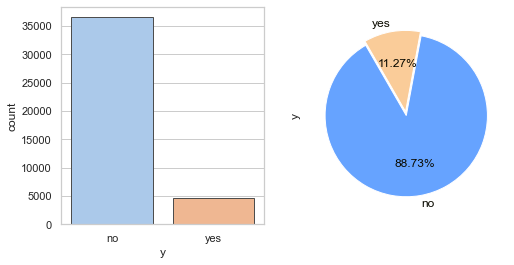

In [8]:
#show target (no, yes) population
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(8,4))
labels=['no','yes']
sns.countplot(x=df.y, data=df, palette="pastel",ax=ax[0], edgecolor=".3")
df.y.value_counts().plot.pie(autopct="%1.2f%%", ax=ax[1], 
                             colors=['#66a3ff','#facc99'], 
                             labels=labels, explode = (0, 0.05), startangle=120,
                             textprops={'fontsize': 12, 'color':'#0a0a00'})
plt.show()

The target is not balanced. The target with no is about 8 times more than the target with yes. It is necessary to balance the data during modeling. This is done either by changing the class weight in the algorithms or sampling the data to make it balance. 


In [10]:
#check how the features are separated by the target 
df.groupby(['y']).agg(['mean', 'std', 'min', 'max']).T

y                        no     yes
age            mean   39.91   40.91
               std     9.90   13.84
               min    17.00   17.00
               max    95.00   98.00
duration       mean  220.87  553.26
               std   207.12  401.19
               min     0.00   37.00
               max  4918.00 4199.00
campaign       mean    2.63    2.05
               std     2.87    1.67
               min     1.00    1.00
               max    56.00   23.00
pdays          mean  984.11  791.99
               std   120.67  403.44
               min     0.00    0.00
               max   999.00  999.00
previous       mean    0.13    0.49
               std     0.41    0.86
               min     0.00    0.00
               max     7.00    6.00
emp.var.rate   mean    0.25   -1.23
               std     1.48    1.62
               min    -3.40   -3.40
               max     1.40    1.40
cons.price.idx mean   93.60   93.35
               std     0.56    0.68
               min    92.20   92.20
               max    94.77   94.77
cons.conf.idx  mean  -40.59  -39.79
               std     4.39    6.14
               min   -50.80  -50.80
               max   -26.90  -26.90
euribor3m      mean    3.81    2.12
               std     1.64    1.74
               min     0.63    0.63
               max     5.04    5.04
nr.employed    mean 5176.17 5095.12
               std    64.57   87.58
               min  4963.60 4963.60
               max  5228.10 5228.10

In [11]:
#replace no/yes by 0/1
df['y'].replace(['no', 'yes'], [0, 1], inplace=True)

In [90]:
#split DF into numerical and categorical for better manipulation
df_num=df.select_dtypes(include=['number'])
df_cat=df.select_dtypes(exclude=['number'])
df_num.shape, df_cat.shape

((41176, 11), (41176, 10))

<b>3a. Explore the numerical data</b>

**Check the outlies.** Scale them so as to plot all together.

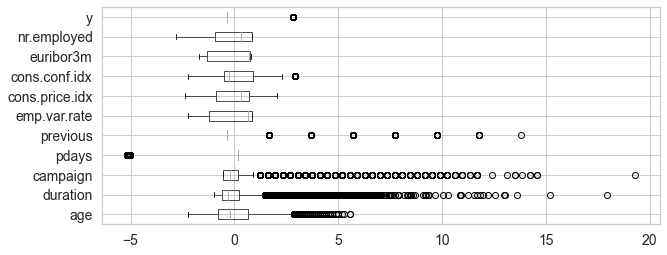

In [54]:
# scale_type='Robust', 'MinMax', 'Standard'
df0=ut.data_scale(df_num, data_type='df', scale_type='Standard')
df0.boxplot(rot=0, fontsize=14, figsize=(10, 4), vert=False )
plt.show()

<b>Check histogram </b> (0 for blue,  1 for brown)

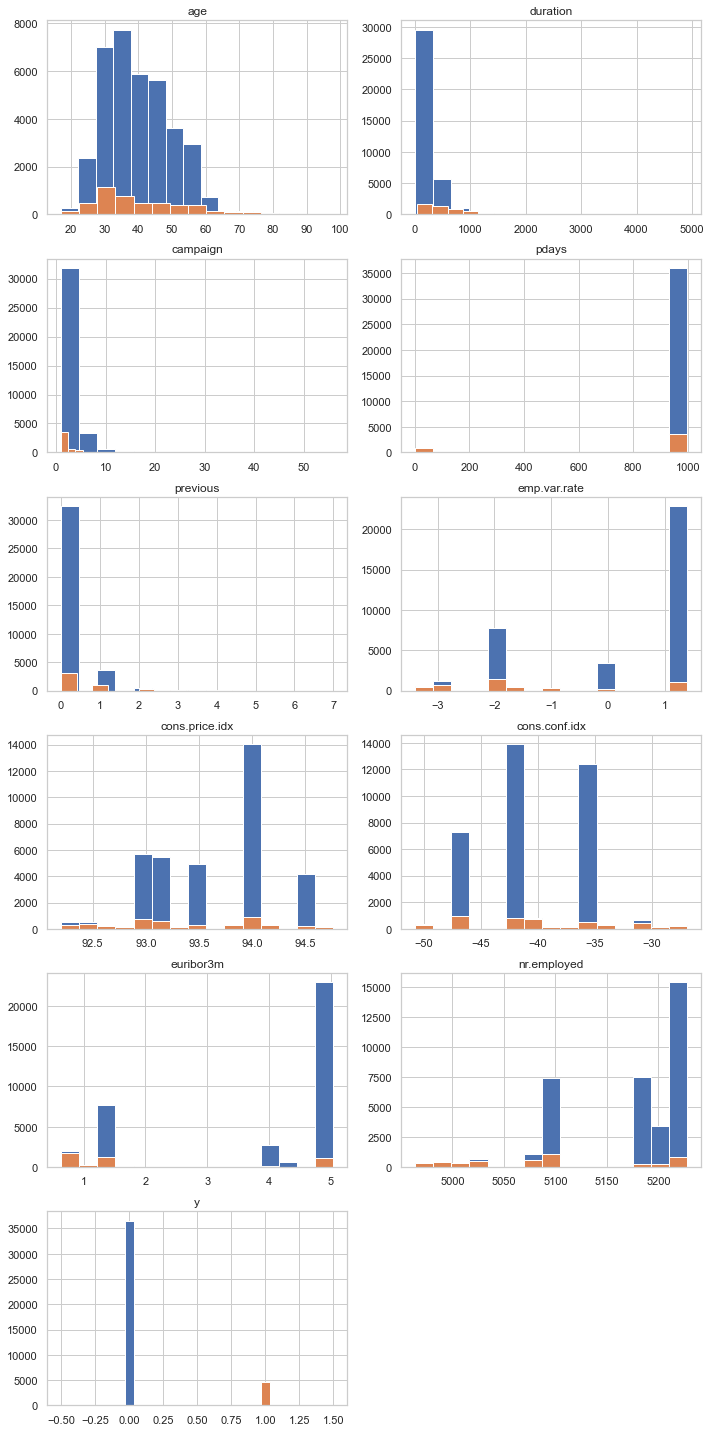

In [55]:
col=list(df_num.columns)
ut.plot_hist_class(df_num, col, nrow=6, ncol=2,  target='y', figsize=(10,20))

<b>Check the density plot </b> to see how well the target is separated for each feature: 

<br>Observations:
1. The 'duration', 'emp.var.rate', 'euribor3m', 'nr.employed'  separated the target well

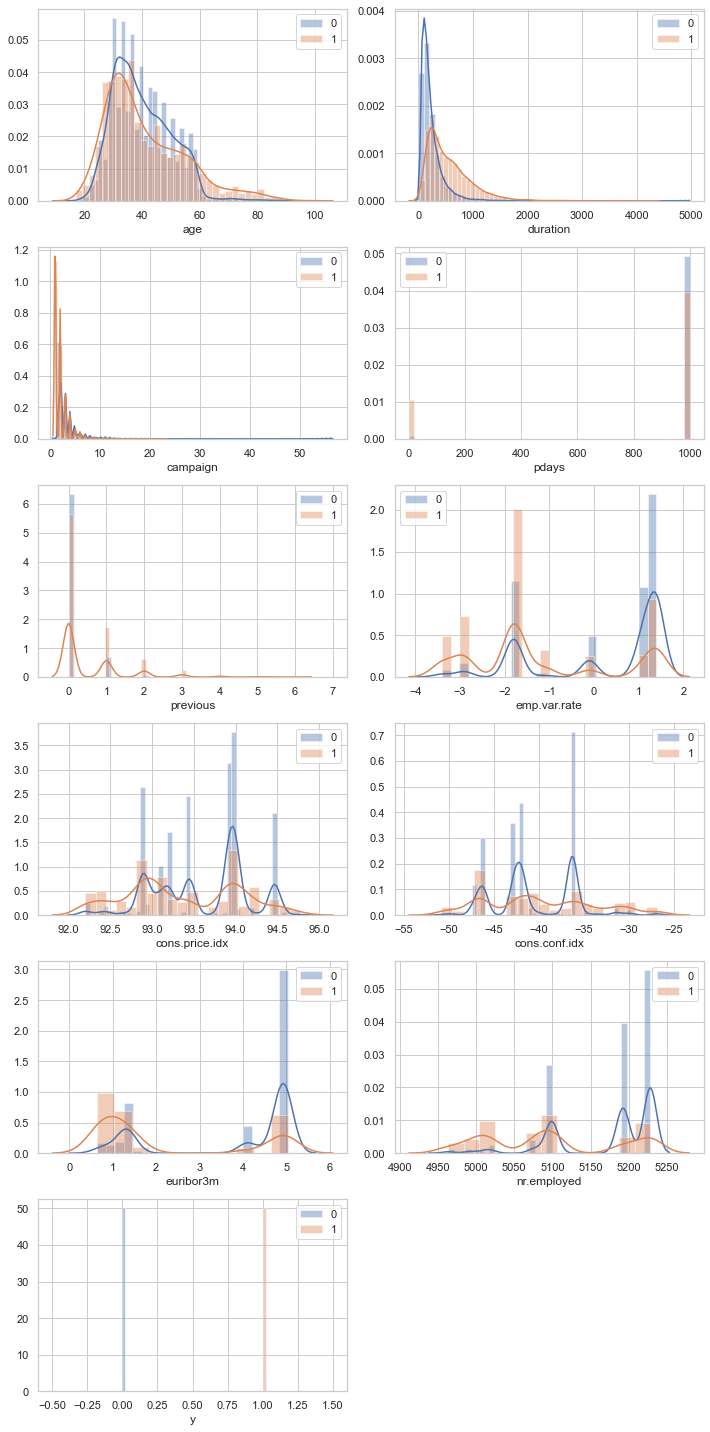

In [56]:
col=list(df_num.columns)
ut.plot_density_class(df_num, col, nrow=6, ncol=2, figsize=(10,20), target='y')


Plot heatmap to show correlations among the numerical features.


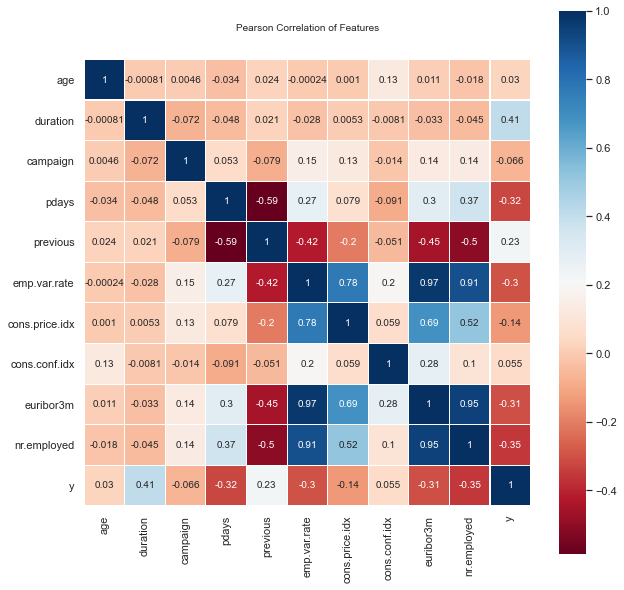

In [57]:
#check correlations
ut.plot_corr(df_num, figsize=(10,10))

In [91]:
#check if exist heavy correlation
#dir(ut)
d=ut.find_corr_columns(df_num, threshold=0.95)


features with correlation > threshold= ['euribor3m']


In [92]:
#remove the heavy correlated feature
df_num.drop(['euribor3m'], axis=1, inplace=True)

<b>Final manipulation of the numerical data:</b>

The feature <font color='red'> duration </font> is removed due to the reason as indicated in the data sets as below: <br>

<i>last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. </i>


In [93]:
df_num.drop(['duration'], axis=1, inplace=True)

<b>3b. Explore the categorical data</b>

In [70]:
#reduce categorical level for education
df_cat['education'].replace(['basic.4y','basic.6y','basic.9y'], 
                           ['basic','basic','basic'], inplace=True)
df_cat['education'].replace(['unknown','illiterate'], 
                           ['other','other'], inplace=True)

In [94]:
def check_target(df, col='', target=''):
  '''check how the target is distributed in each level
  '''
  d1=df[df[target]==0][col].value_counts().to_frame()
  d2=df[df[target]==1][col].value_counts().to_frame()

#pd.merge(d1, d2, left_index=True, right_index=True)
  dd=pd.concat([d1,d2], axis=1)
#  dd.columns=[col+'_no', col+'_yes']
  dd.columns=['no', 'yes']
  dd['ratio_yes/no'] = dd['yes']/dd['no']

  return dd

<b>Check how categorical data seperated the target</b>. Observations below:
1. for Job: Student and retired people are the highest ratios and blue-collar is the lowest.
2. for contact: There is a big difference betwee telephone and cellular.
3. fop month: Mar, Sep, Oct, Dec have the very high rate, although there are not many counts.
4. for poutcome: The rate is significantly high when the last campain was success.

In [96]:
df_cat['y']=df_num['y']
for col in list(df_cat.columns):
  print ('\n-------checking feature--------',col)
  print(check_target(df_cat, col=col, target='y'))



-------checking feature-------- job
                 no   yes  ratio_yes/no
admin.         9068  1351          0.15
blue-collar    8615   638          0.07
technician     6009   730          0.12
services       3644   323          0.09
management     2596   328          0.13
entrepreneur   1332   124          0.09
retired        1284   434          0.34
self-employed  1272   149          0.12
housemaid       954   106          0.11
unemployed      870   144          0.17
student         600   275          0.46
unknown         293    37          0.13

-------checking feature-------- marital
             no   yes  ratio_yes/no
married   22390  2531          0.11
single     9944  1620          0.16
divorced   4135   476          0.12
unknown      68    12          0.18

-------checking feature-------- education
                        no   yes  ratio_yes/no
university.degree    10495  1669          0.16
high.school           8481  1031          0.12
basic.9y              5572   473      

In [97]:
#remove columns y
df_cat.drop(['y'], axis=1, inplace=True)

In [98]:
#add dummy variables (regression need number), drop the first one (duplicated)
df_cat=pd.get_dummies(df_cat, drop_first=True)
print(f'Dimensions after one-hot encode {df_cat.shape}')

Dimensions after one-hot encode (41176, 43)


In [ ]:
#plot histogram for categorical data
#for f in col: ut.plot_hist_class_one(df,  target='y', feature=[f], figsize=(8,4))

In [ ]:
# drop/assign the row if the ratio is too low.
#df_test=ut.assign_other(df_num, col=['age'],val=0.0001, action='drop')

# **4 Binary classification**

The feature <font color='red'> duration </font> is removed throughout all the modeling: <br>



**4a.   Classification using the numerical data only!**


In [113]:
#drop the duration for business reason
df_final=df_num.copy()
X_train, X_test, y_train, y_test = ut.split_data(df_final, size=0.30, 
                                                 target='y', stratify='yes')

shape of X=(41176, 8), X_train=(28823, 8),  X_test=(12353, 8)


In [114]:
#select the best features (RFE is very slow)
#X_train, X_test=ut.feature_selection(X_train, X_test, y_train, y_test, 'RFE', 8)
#X_train_s, X_test_s=ut.feature_selection(X_train, X_test, y_train, y_test, 'model_RF', 8)
X_train_s, X_test_s=ut.feature_selection(X_train, X_test, y_train, y_test, 'model_XGB', 8)


Feature selection:  using ftype= model_XGB nfeature= 8
[11:37:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The shape of X_train =  (28823, 8)
The shape of X_train_select =  (28823, 8)
[11:37:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          feature  importance
7     nr.employed        0.79
4    emp.var.rate        0.05
2           pdays        0.05
6   cons.conf.idx        0

In [115]:
#tuning paramters (Note: the testing is not used for training!)

tune.tune_classifier_all(X_train_s, y_train, X_test_s, y_test,tune=1)
#tune.tune_classifier('RandomForestClassifier', X_train_s, y_train, X_test_s, y_test,tune=1)
#tune.tune_classifier('XGBClassifier', X_train_s, y_train, X_test_s, y_test, tune=1)


------------------------------------------------------------------

Tuning hyperparameters for  RandomForestClassifier
input_params= {'criterion': ['gini', 'entropy'], 'max_depth': [6, 4, 2, None], 'n_estimators': [200], 'max_features': ['auto', None]}

best_train_score=0.900: best_test_score=0.899 : CPU time= 25.09 s
best_params= {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}
model= RandomForestClassifier(max_depth=4, n_estimators=200)

------------------------------------------------------------------

Tuning hyperparameters for  AdaBoostClassifier
input_params= {'n_estimators': [200], 'algorithm': ['SAMME', 'SAMME.R']}

best_train_score=0.899: best_test_score=0.899 : CPU time= 3.88 s
best_params= {'algorithm': 'SAMME', 'n_estimators': 200}
model= AdaBoostClassifier(algorithm='SAMME', n_estimators=200)

------------------------------------------------------------------

Tuning hyperparameters for  GradientBoostingClassifier
input_params= {'n_estim

[11:48:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Confusion_matrix=
 [[10006   955]
 [  599   793]]
Classification_report=
               precision    recall  f1-score   support

           0       0.94      0.91      0.93     10961
           1       0.45      0.57      0.51      1392

    accuracy                           0.87     12353
   macro avg       0.70      0.74      0.72     12353
weighted avg       0.89      0.87      0.88     12353

Classification accuracy= 0.8742005990447664
Classification AUC_ROC=  0.8014468683115791


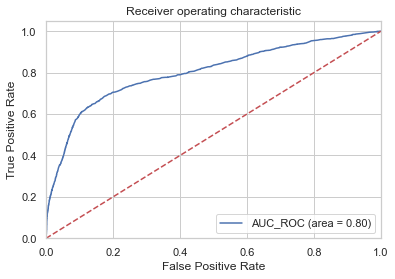

In [117]:
#run the model
model= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, seed=None,
              silent=None, subsample=1, verbosity=1)

model.fit(X_train_s, y_train)  #fit the model 
y_pred = model.predict(X_test_s)
ut.write_result_class(X_test_s, y_test, y_pred,  model)

<b>Observations from modeling using the numerical data: </b><br>
1. grid search was used to tune the hyperparameters. The Classifiers and the scores are listed below.
<pre>
The table for each model
                      model_inp  train_score  test_score   cpu
0           LogisticRegression         0.90        0.90  3.59
1       RandomForestClassifier         0.90        0.90 25.09
2         ExtraTreesClassifier         0.90        0.90 13.38
3       DecisionTreeClassifier         0.90        0.90  0.42
4           AdaBoostClassifier         0.90        0.90  3.88
5                XGBClassifier         0.90        0.90 13.21
6         KNeighborsClassifier         0.90        0.90  8.95
7                MLPClassifier         0.90        0.90  4.77
8   LinearDiscriminantAnalysis         0.90        0.89  0.28
9   GradientBoostingClassifier         0.91        0.89 11.26
10                 BernoulliNB         0.89        0.89  0.16
11                  GaussianNB         0.87        0.87  0.06
12                   LinearSVC         0.11        0.11  8.86 

</pre>

2. When adjusting class weight to balance the target, XGBClassifier became slightly better. The final stats is from XGB.


<b>4b. Classification using the categorical data only! </b>

In [118]:
#add target y to df_cat
df_final=df_cat.copy()
df_final['y']=df_num['y']
X_train, X_test, y_train, y_test = ut.split_data(df_final, size=0.30, 
                                                 target='y', stratify='yes')

shape of X=(41176, 43), X_train=(28823, 43),  X_test=(12353, 43)


In [119]:
#select the best features (RFE is very slow)
#X_train, X_test=ut.feature_selection(X_train, X_test, y_train, y_test, 'RFE', 20)
X_train_s, X_test_s=ut.feature_selection(X_train, X_test, y_train, y_test, 'model_XGB', 25)


Feature selection:  using ftype= model_XGB nfeature= 25
[11:53:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The shape of X_train =  (28823, 43)
The shape of X_train_select =  (28823, 25)
[11:53:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                          feature  importance
24               poutcome_success        0.24
17                      month_mar        0.11
20   

In [120]:
#only use XGB for a fast check!
tune.tune_classifier_all(X_train_s, y_train, X_test_s, y_test,tune=1)
#tune.tune_classifier('RandomForestClassifier', X_train_s, y_train,X_test_s, y_test,tune=1)
#tune.tune_classifier('XGBClassifier', X_train_s, y_train, X_test_s, y_test,tune=1)



------------------------------------------------------------------

Tuning hyperparameters for  RandomForestClassifier
input_params= {'criterion': ['gini', 'entropy'], 'max_depth': [6, 4, 2, None], 'n_estimators': [200], 'max_features': ['auto', None]}

best_train_score=0.898: best_test_score=0.897 : CPU time= 29.61 s
best_params= {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}
model= RandomForestClassifier(max_depth=6, n_estimators=200)

------------------------------------------------------------------

Tuning hyperparameters for  AdaBoostClassifier
input_params= {'n_estimators': [200], 'algorithm': ['SAMME', 'SAMME.R']}

best_train_score=0.898: best_test_score=0.896 : CPU time= 4.75 s
best_params= {'algorithm': 'SAMME', 'n_estimators': 200}
model= AdaBoostClassifier(algorithm='SAMME', n_estimators=200)

------------------------------------------------------------------

Tuning hyperparameters for  GradientBoostingClassifier
input_params= {'n_estim

[12:04:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Confusion_matrix=
 [[10240   721]
 [  765   627]]
Classification_report=
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     10961
           1       0.47      0.45      0.46      1392

    accuracy                           0.88     12353
   macro avg       0.70      0.69      0.70     12353
weighted avg       0.88      0.88      0.88     12353

Classification accuracy= 0.8797053347365013
Classification AUC_ROC=  0.7768812912447163


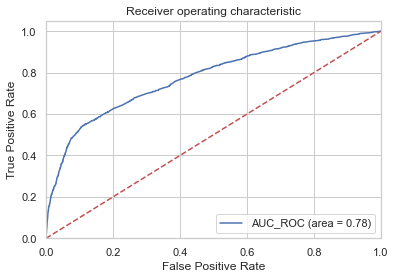

In [121]:
# Create and run the model (fit and predict)


model= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1,  monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

model.fit(X_train_s, y_train)  #fit the model 
y_pred = model.predict(X_test_s)
ut.write_result_class(X_test_s, y_test, y_pred,  model)


<b>Observation from the above modeling:</b> <br>
1. The prediction using the categorical data is only slightly worse than that using numerical values.

**4c. Classification using all features (categorical + numerical)**

In [122]:
df1=pd.concat([df_num, df_cat], axis=1)
df1.shape

(41176, 52)

In [123]:
df_final=df1.copy()
X_train, X_test, y_train, y_test = ut.split_data(df_final, size=0.30, 
                                                 target='y', stratify='yes')

shape of X=(41176, 51), X_train=(28823, 51),  X_test=(12353, 51)


In [131]:
#select the best features (RFE is very slow)
#X_train, X_test=ut.feature_selection(X_train, X_test, y_train, y_test, 'RFE', 20)
X_train_s, X_test_s=ut.feature_selection(X_train, X_test, y_train, y_test, 'model_XGB', 30)

Feature selection:  using ftype= model_XGB nfeature= 30
[12:17:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The shape of X_train =  (28823, 51)
The shape of X_train_select =  (28823, 30)
[12:17:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                          feature  importance
5                     nr.employed        0.46
29               poutcome_success        0.06
24   

In [125]:
#only use XGB for a fast check!
#tune.tune_classifier_all(X_train_s, y_train, X_test_s, y_test,tune=1)
tune.tune_classifier('XGBClassifier', X_train_s, y_train, X_test_s, y_test,tune=1)


------------------------------------------------------------------

Tuning hyperparameters for  XGBClassifier
input_params= {'max_depth': [2, 5, 7, 9], 'subsample': [1], 'n_estimators': [200], 'colsample_bytree': [1]}
[12:09:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

best_train_score=0.900: best_test_score=0.899 : CPU time= 28.21 s
best_params= {'colsample_bytree': 1, 'max_depth': 2, 'n_estimators': 200, 'subsample': 1}
model= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_de

['XGBClassifier',
 0.9051451965444264,
 0.8992957176394398,
 28.20777702331543,
 {'colsample_bytree': 1, 'max_depth': 2, 'n_estimators': 200, 'subsample': 1},
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=2,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)]

[12:17:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Confusion_matrix=
 [[10033   928]
 [  588   804]]
Classification_report=
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     10961
           1       0.46      0.58      0.51      1392

    accuracy                           0.88     12353
   macro avg       0.70      0.75      0.72     12353
weighted avg       0.89      0.88      0.88     12353

Classification accuracy= 0.8772767748725006
Classification AUC_ROC=  0.8040430963698881


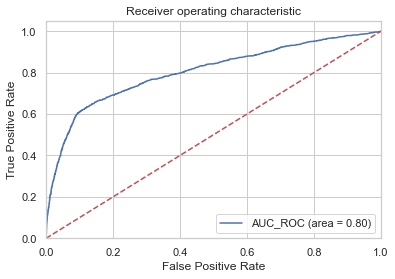

In [132]:
# Create and run the model (fit and predict)

model= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1,  monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)



model.fit(X_train_s, y_train)  #fit the model 
y_pred = model.predict(X_test_s)
ut.write_result_class(X_test_s, y_test, y_pred,  model)


Observations: <br>
1. Classification using the full features are better than using either numerical or categorical data.


**4d. Classification based on the synthesized full data set by SMOTE**
<br>
Only the training data is over-sampled so that no data leak will happen.
<br>
Fit the model using the oversampled data, but prediction using the original data!

In [122]:
X_train_sm, y_train_sm=ut.resample_imbalanced_data(X_train_s, y_train, types='SMOTE', 
                                                   ratio=1.0, target='y')

Prog: SMOTE;  # of original X=28823; # of resampled X=51152; perc=1.8e+02%
After Sampling, the shape of X: (51152, 30)
After Sampling, counts of label '1': 25576
After Sampling, counts of label '0': 25576


In [120]:
# Use the selected features 
tune.tune_classifier('XGBClassifier', X_train_sm, y_train_sm, X_test_s, y_test, tune=1)


------------------------------------------------------------------

Tuning hyperparameters for  XGBClassifier
input_params= {'max_depth': [2, 5, 7, 9], 'subsample': [1], 'n_estimators': [200], 'colsample_bytree': [1]}

best_train_score=0.923: best_test_score=0.896 : CPU time= 195.05 s
best_params= {'colsample_bytree': 1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1}
model= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


['XGBClassifier',
 0.9616455547276364,
 0.8955719258479722,
 195.0489375591278,
 {'colsample_bytree': 1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1},
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=9,
               min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1)]


Confusion_matrix=
 [[9780 1181]
 [ 565  827]]
Classification_report=
               precision    recall  f1-score   support

           0       0.95      0.89      0.92     10961
           1       0.41      0.59      0.49      1392

    accuracy                           0.86     12353
   macro avg       0.68      0.74      0.70     12353
weighted avg       0.89      0.86      0.87     12353

Classification accuracy= 0.8586578159151623
Classification AUC_ROC=  0.7946210087069411


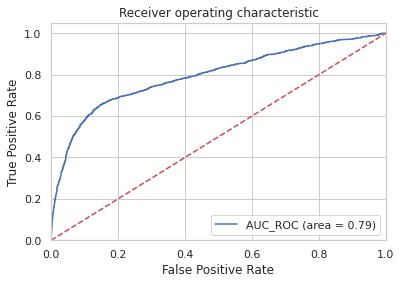

In [130]:
model= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, seed=None,
              silent=None, subsample=1, verbosity=1)


model.fit(X_train_sm, y_train_sm)  #fit the model to sampled data

y_pred = model.predict(X_test_s)  #predict against the original data
ut.write_result_class(X_test_s, y_test, y_pred,  model)



In [132]:
# Do cross validation 
from sklearn import model_selection

print ('Perform 5 folder cross validation for the training data.')
kfold = model_selection.KFold(n_splits=5, random_state=7)
cv_results = model_selection.cross_val_score(model,X_train, y_train, cv=kfold, scoring='accuracy')
msg = "\n%s: \n\naccuracy=%f (std=%f)" % (model, cv_results.mean(), cv_results.std())
print(msg)


Perform 5 folder cross validation for the training data.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, seed=None,
              silent=None, subsample=1, verbosity=1): 

accuracy=0.873296 (std=0.004500)


<b> 4e. Classification by Convolutional Neuro network CNN (use CONV1D) </b>

In [162]:
#standarize the training and testing data (Robust, MinMax, Standard)
#NN needs numpy data type.(data_type='np' or 'df')
X_train_nn, X_test_nn=ut.data_scalor(X_train_s, X_test_s, data_type='np',scale_type='MinMax')
X_train_nn.shape, X_test_nn.shape, type(X_train_nn),type(X_test_nn)

((28823, 30), (12353, 30), numpy.ndarray, numpy.ndarray)

In [202]:
#-----------next try a different approch of NN Conv1D--------------------
#Note: neuron network accept 3 D data (convert np first)

xnn_train=np.array(X_train_nn).reshape(X_train_nn.shape[0],X_train_nn.shape[1],1)
xnn_test=np.array(X_test_nn).reshape(X_test_nn.shape[0],X_test_nn.shape[1],1)
xnn_train.shape, xnn_test.shape , X_train_nn.shape

((28823, 30, 1), (12353, 30, 1), (28823, 30))

In [224]:
#build model !

#creat the architecture
model=Sequential()

#convolution layer
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(xnn_test.shape[1],1)))
model.add(BatchNormalization())
#model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  #drop 20% neurons randomly

#the second layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
#model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  #drop 20% neurons randomly

#Flatten layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) #prevent overfitting

#Note: here the activation makes a huge difference
#model.add(Dense(1, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))



In [213]:
#print(model.summary())

In [225]:
#model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00005), metrics=['accuracy'])
history=model.fit(xnn_train, y_train, epochs=10, validation_split=0.30, verbose=1)

Epoch 1/10
631/631 [==============================] - 10s 13ms/step - loss: 0.5419 - accuracy: 0.8181 - val_loss: 0.2926 - val_accuracy: 0.8933
Epoch 2/10
631/631 [==============================] - 9s 14ms/step - loss: 0.3980 - accuracy: 0.8748 - val_loss: 0.3045 - val_accuracy: 0.8945
Epoch 3/10
631/631 [==============================] - 8s 13ms/step - loss: 0.3675 - accuracy: 0.8800 - val_loss: 0.3415 - val_accuracy: 0.8955
Epoch 4/10
631/631 [==============================] - 8s 13ms/step - loss: 0.3333 - accuracy: 0.8913 - val_loss: 0.3509 - val_accuracy: 0.8966
Epoch 5/10
631/631 [==============================] - 8s 13ms/step - loss: 0.3357 - accuracy: 0.8875 - val_loss: 0.3502 - val_accuracy: 0.8971
Epoch 6/10
631/631 [==============================] - 8s 13ms/step - loss: 0.3289 - accuracy: 0.8921 - val_loss: 0.3470 - val_accuracy: 0.8966
Epoch 7/10
631/631 [==============================] - 9s 14ms/step - loss: 0.3104 - accuracy: 0.8978 - val_loss: 0.3484 - val_accuracy: 0.896

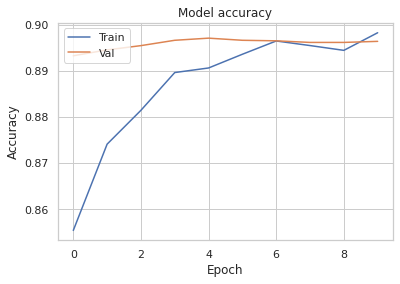

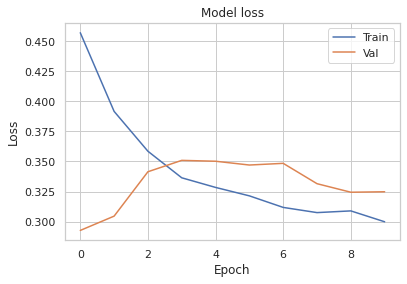

In [226]:
#look at the history
#print(history.history)
ut.plot_deep_learning_curve(history)


Confusion_matrix=
 [[10855   106]
 [ 1158   234]]
Classification_report=
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     10961
           1       0.69      0.17      0.27      1392

    accuracy                           0.90     12353
   macro avg       0.80      0.58      0.61     12353
weighted avg       0.88      0.90      0.87     12353

387/387 [==============================] - 1s 3ms/step - loss: 0.3197 - accuracy: 0.8977
Loss & accuracy= [0.3197123408317566, 0.8976767063140869]
Classification AUC_ROC=  0.7928512479459567


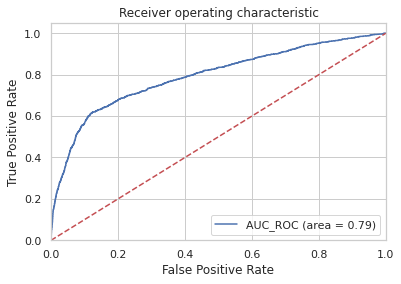

In [227]:
ut.write_cnn_result(x_test, y_test, model)

<b>4f. LogisticRegression based on the synthesized full data set</b> <br>
Note: <br>
1. use as much as possible data for training.
2. The coefficients of LogisticRegression gives the probability of the predictor. If coeff < 0, the probability decrease when this predictor increases a unit, when other are fixed. If coeff > 0, the probability increase amount when this predictor increases a unit, when other are fixed. 


In [134]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_final=df1.copy()
X_train, X_test, y_train, y_test = ut.split_data(df_final, size=0.01, 
                                                 target='y', stratify='no')

shape of X=(41176, 51), X_train=(40764, 51),  X_test=(412, 51)


In [135]:
X_train_s, X_test_s=ut.feature_selection(X_train, X_test, y_train, y_test, 'model_XGB', 30)

Feature selection:  using ftype= model_XGB nfeature= 30
[12:21:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The shape of X_train =  (40764, 51)
The shape of X_train_select =  (40764, 30)
[12:21:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                          feature  importance
6                     nr.employed       0.505
29               poutcome_success       0.067
25   

In [136]:
xx=X_train_s.reset_index(drop=True)
yy=y_train.reset_index(drop=True)
xx=sm.add_constant(xx) #add a constant for Logit

logit_model=sm.Logit(yy,xx)
#result=logit_model.fit(method='bfgs', maxiter=1000)
result=logit_model.fit_regularized(penalty='l2', class_weight='balanced')
#result=logit_model.fit_regularized(penalty='l1')
#result=logit_model.fit()
print(result.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.27678184802103156
            Iterations: 226
            Function evaluations: 241
            Gradient evaluations: 226
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40764
Model:                          Logit   Df Residuals:                    40733
Method:                           MLE   Df Model:                           30
Date:                Sun, 06 Jun 2021   Pseudo R-squ.:                  0.2135
Time:                        12:21:57   Log-Likelihood:                -11283.
converged:                       True   LL-Null:                       -14345.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

Note: The coefficients with Pvalue < 0.05 are not statistically significant. 